Workload & learning plan (next 30 days)


/var/folders/z9/j5ml_rlj0bl6bq9136k9lb8r0000gn/T/ipykernel_26126/2753677336.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return dt.datetime.utcfromtimestamp(raw / 1000)
/var/folders/z9/j5ml_rlj0bl6bq9136k9lb8r0000gn/T/ipykernel_26126/2753677336.py:21: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return dt.datetime.utcfromtimestamp(int(raw[2:]) / 1000)


,scheduled_reviews,headroom,learn_new
2025-07-09,0,30,5
2025-07-10,1,29,5
2025-07-11,13,17,5
2025-07-12,6,24,5
2025-07-13,1,29,5
2025-07-14,0,30,5
2025-07-15,8,22,5
2025-07-16,6,24,5
2025-07-17,0,30,5
2025-07-18,0,30,5



Unlearned cards remaining after schedule: 0


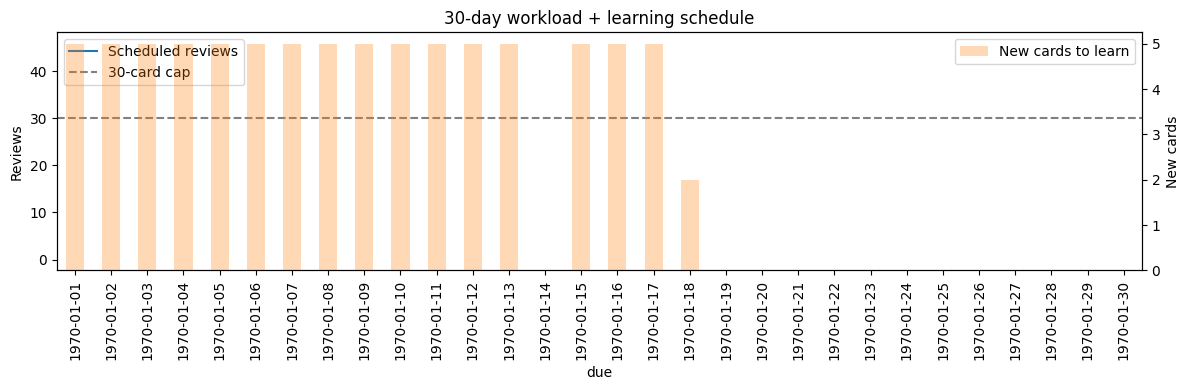

In [12]:
import sqlite3, json, math, datetime as dt, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ─────────────────────────────────────────────────────────────────────────────
# 1.  Load cards & reviews  ── also collect *unlearned* cards (zero reviews)
# ─────────────────────────────────────────────────────────────────────────────
DB_PATH = "mochi.db"
MS_DAY = 86_400_000



def ms_to_dt(raw):
    """Convert Mochi's date encodings to a Python datetime (UTC)."""
    # case 1 ─ plain integer milliseconds
    if isinstance(raw, (int, float)):
        return dt.datetime.utcfromtimestamp(raw / 1000)

    # case 2 ─ Transit string like "~t1723014000000"
    if isinstance(raw, str) and raw.startswith("~t"):
        return dt.datetime.utcfromtimestamp(int(raw[2:]) / 1000)

    raise ValueError(f"Unrecognised Mochi date format: {raw!r}")


def interval_of(r):
    if "~:interval" in r:
        return r["~:interval"]
    if "~:due" in r and "~:date" in r:
        return max(
            round((int(r["~:due"][2:]) - int(r["~:date"][2:])) / MS_DAY), 0
        )
    return math.nan


rows, deck_name, unlearned = [], {}, []

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()

    # deck lookup ──────────────────────────────────────
    cur.execute(
        'SELECT json FROM "by-sequence" WHERE json LIKE \'%"type":"deck"%\''
    )
    for (doc,) in cur.fetchall():
        td = json.loads(doc)["transit-data"]
        deck_name[td["~:id"]] = td["~:name"]

    # cards + reviews ──────────────────────────────────
    cur.execute(
        'SELECT json FROM "by-sequence" WHERE json LIKE \'%"type":"card"%\''
    )
    for (doc,) in cur.fetchall():
        td = json.loads(doc)["transit-data"]
        deck = td["~:deck-id"]

        if td["~:reviews"]:  # learned card
            for r in td["~:reviews"]:
                rows.append(
                    {
                        "deck": deck_name.get(deck, deck),
                        "card_id": td["~:id"],
                        "when": ms_to_dt(r["~:date"]),
                        "interval": interval_of(r),
                    }
                )
        else:  # never reviewed → unlearned
            unlearned.append(
                {
                    "card_id": td["~:id"],
                    "deck": deck_name.get(deck, deck),
                    "created": ms_to_dt(td["~:created-at"]["~#dt"]),
                }
            )

reviews = pd.DataFrame(rows)
reviews["when"] = pd.to_datetime(reviews["when"])
unlearned_df = pd.DataFrame(unlearned)

# ─────────────────────────────────────────────────────────────────────────────
# 2.  Forecast existing workload & head-room
# ─────────────────────────────────────────────────────────────────────────────
CAP_REVIEW = 30  # max reviews you accept on any day
HORIZON_DAYS = 30

latest = (
    reviews.sort_values("when")
    .groupby("card_id", as_index=False)
    .tail(1)
    .dropna(subset=["interval"])
)
latest["due"] = latest["when"] + pd.to_timedelta(latest.interval, unit="D")

rng = pd.date_range(dt.date.today(), periods=HORIZON_DAYS, name="date")
due_cnt = (
    latest.groupby(latest["due"].dt.date)
    .size()
    .reindex(rng.date, fill_value=0)
)

headroom_day = (CAP_REVIEW - due_cnt).clip(lower=0)

# ─────────────────────────────────────────────────────────────────────────────
# 3.  Build learning schedule for unlearned cards
# ─────────────────────────────────────────────────────────────────────────────
LEARN_CAP_DAY = 5  # how many brand-new cards/day you can handle
remaining = len(unlearned_df)
learn_plan = pd.Series(0, index=rng.date, name="new_cards_to_learn")

for day in learn_plan.index:
    if remaining == 0:
        break
    slots = min(headroom_day[day], LEARN_CAP_DAY)
    if slots:
        add = min(slots, remaining)
        learn_plan[day] = add
        remaining -= add

# combined dashboard table
dashboard = pd.DataFrame(
    {
        "scheduled_reviews": due_cnt,
        "headroom": headroom_day,
        "learn_new": learn_plan,
    }
)
print("Workload & learning plan (next 30 days)")
display(dashboard.head(10))  # drop or keep depending on environment

print(f"\nUnlearned cards remaining after schedule: {remaining}")

# ─────────────────────────────────────────────────────────────────────────────
# 4.  Plot: workload + head-room + new-card plan
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 4))
due_cnt.plot(label="Scheduled reviews", ax=ax, color="tab:blue")
ax.axhline(CAP_REVIEW, ls="--", color="grey", label=f"{CAP_REVIEW}-card cap")

ax2 = ax.twinx()  # secondary axis
learn_plan.plot(
    kind="bar",
    ax=ax2,
    alpha=0.3,
    color="tab:orange",
    label="New cards to learn",
)

# daily ticks
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.tick_params(axis="x", rotation=90)

ax.set_ylabel("Reviews")
ax2.set_ylabel("New cards")
ax.set_title("30-day workload + learning schedule")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

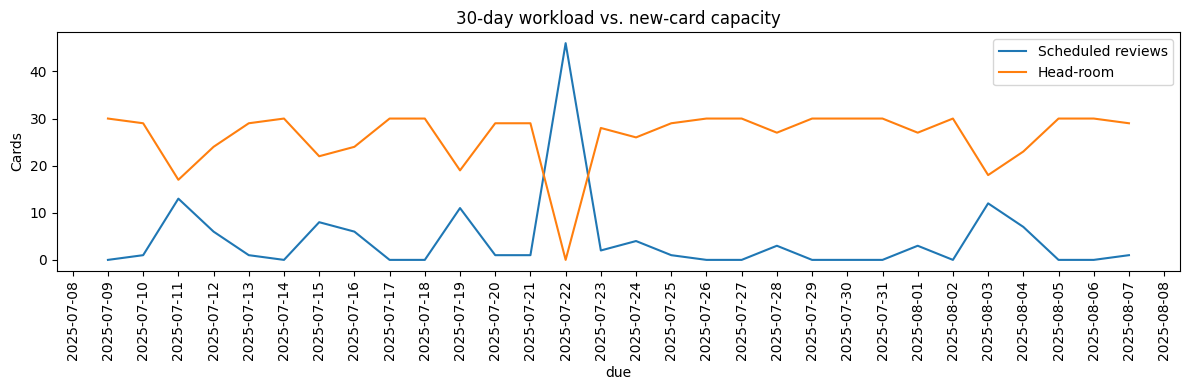

In [17]:
import matplotlib.dates as mdates  # ← add this import once at top

fig, ax = plt.subplots(figsize=(12, 4))
due_cnt.plot(kind="line", label="Scheduled reviews", ax=ax)
headroom_per_day.plot(kind="line", label="Head-room", ax=ax)

# NEW: show *every* day as an x-tick
ax.xaxis.set_major_locator(mdates.DayLocator())  # one tick per day
ax.xaxis.set_major_formatter(
    mdates.DateFormatter("%Y-%m-%d")
)  # yyyy-mm-dd labels
ax.tick_params(axis="x", rotation=90)  # slanted labels

ax.set_title("30-day workload vs. new-card capacity")
ax.set_ylabel("Cards")
ax.legend()
plt.tight_layout()